# 1. Set Enviroment

In [1]:
pip install --user PyWavelets

     |████████████████████████████████| 6.3 MB 21 kB/s  eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import normalize
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import os
import csv
import itertools
import collections
import glob
import pywt
import math
import biosppy
import pandas as pd
from scipy import signal

%matplotlib inline

In [3]:
plt.rcParams["figure.figsize"] = (30,6)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.color'] = 'b'
plt.rcParams['axes.grid'] = True

# 2. Process the Data

quantization function for data

In [4]:
def Quant(Vx, Q, RQM):
    return round(Q * Vx) - RQM


def ListQuant(data_list, quant_bits):
    
    data_min = min(data_list)
    data_max = max(data_list)

    
    Q = ((1 << quant_bits) - 1) * 1.0 / (data_max - data_min)
    RQM = (int)(round(Q*data_min))

    
    quant_data_list = []
    for x in data_list:
        quant_data = Quant(x, Q, RQM)
        quant_data_list.append(quant_data)
    quant_data_list = np.array(quant_data_list)
    return (Q, RQM, quant_data_list)

In [5]:
# Variables

path = "./mitDB/"
window_size = 160
maximum_counting = 10000

classes = ['N', 'L', 'R', 'A', 'V', '/']
n_classes = len(classes)
count_classes = [0]*n_classes

X = list()
y = list()

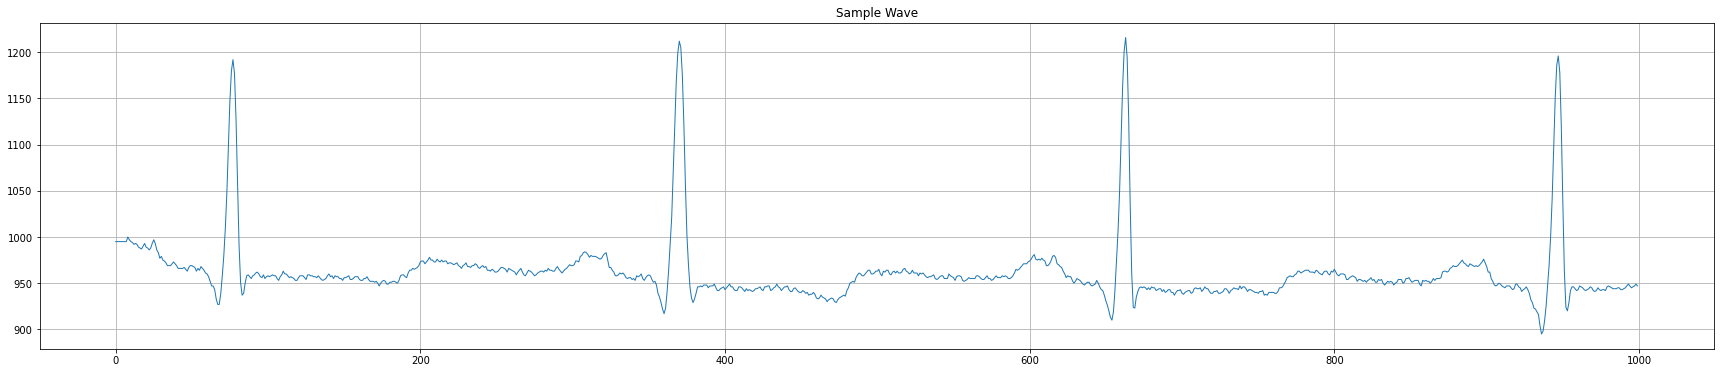

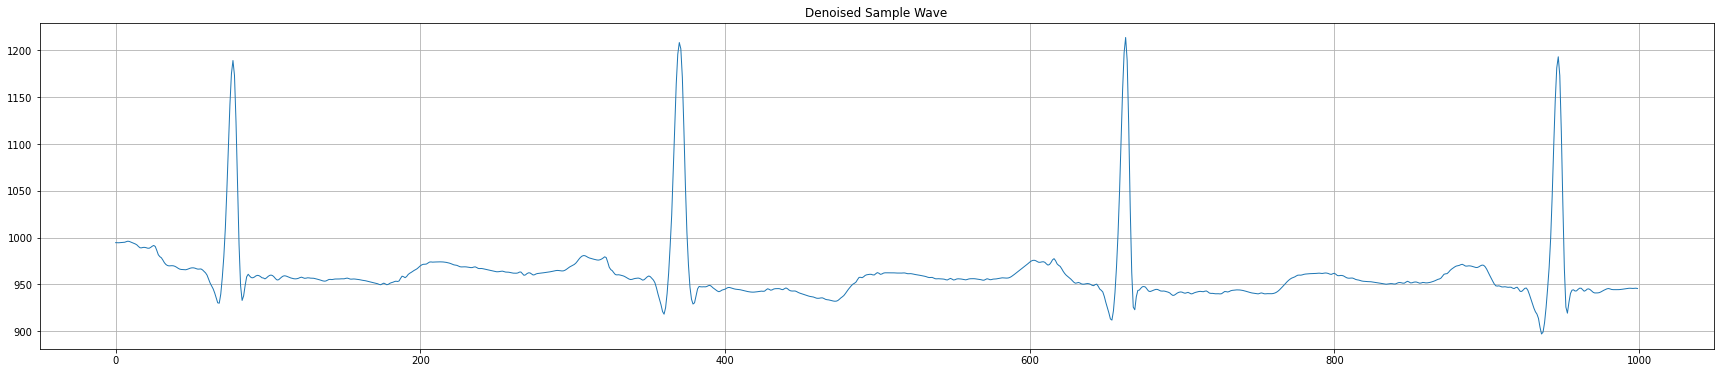

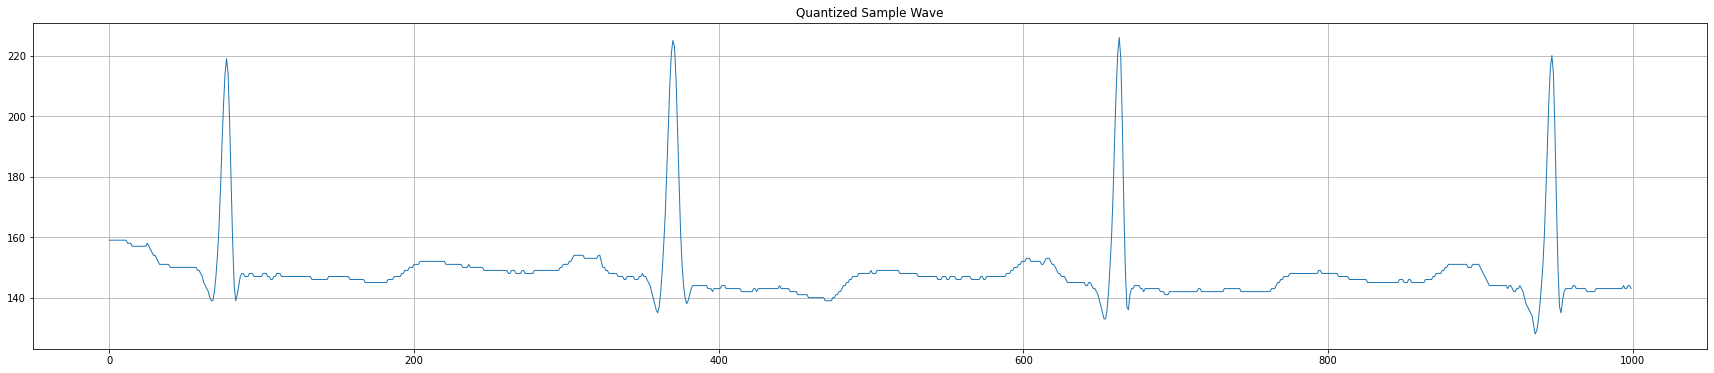

In [6]:
# Read files
filenames = next(os.walk(path))[2]

filenames.sort()

# Split and save .csv , .txt 
records = list()
annotations = list()

for f in filenames:
    filename, file_extension = os.path.splitext(f)
    # *.csv
    if(file_extension == '.csv'):
        records.append(path + filename + file_extension)

    # *.txt
    else:
        annotations.append(path + filename + file_extension)  
# Records
for r in range(0,len(records)):
    signals = []

    with open(records[r], 'rt') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',', quotechar='|') # read CSV file\
        row_index = -1
        for row in spamreader:
            if(row_index >= 0):
                signals.insert(row_index, int(row[1]))
            row_index += 1  
    
    
    
    ###### DWT w/ thresholding #####
    w = pywt.Wavelet('coif5')
    nl = 6
    coeffs = pywt.wavedec(signals, w, level=nl)
    
    # Apply the threshold.  Pseudocode here.
    new_coeffs = []
    for nc in coeffs:
        threshVal = (np.std(signals)/75)*(math.sqrt(2*math.log(len(signals))))
        tcoeff = pywt.threshold(nc, threshVal , mode='soft')
        new_coeffs.append(tcoeff)
    
    # IDWT
    renc = pywt.waverec(new_coeffs, w); 
    
    #Quantization
    renc_Q, renc_RQM, renc_QuantList = ListQuant(renc,quant_bits=8) #set the bit width for quantization
    
        
    if r == 0:
        # Plot first patient's signal
  #         plt.subplot(2,1,1)
        plt.title("Sample Wave")
        plt.plot(signals[:1000])
        plt.show()

  #         plt.subplot(2,1,2)
        plt.title("Denoised Sample Wave")
        plt.plot(renc[:1000])
        plt.show()
        
  #         plt.subplot(2,1,3)
        plt.title("Quantized Sample Wave")
        plt.plot(renc_QuantList[:1000])
        plt.show()
        

    # Read anotations: R position and Arrhythmia class
    with open(annotations[r], 'r') as fileID:
        data = fileID.readlines()
        beat = list()

        for d in range(1, len(data)): # 0 index is Chart Head
            splitted = data[d].split(' ')
            splitted = filter(None, splitted)
            next(splitted) # Time... Clipping
            pos = int(next(splitted)) # Sample ID
            arrhythmia_type = next(splitted) # Type

            if(arrhythmia_type in classes):
                arrhythmia_index = classes.index(arrhythmia_type)
                if count_classes[arrhythmia_index] > maximum_counting: # avoid overfitting
                    pass
                else:
                    count_classes[arrhythmia_index] += 1
                    if(window_size < pos and pos < (len(renc_QuantList) - window_size)):
                        beat = signal.resample(renc_QuantList[pos-window_size+1:pos+window_size],130)
                        X.append(beat)
                        y.append(arrhythmia_index)

In [ ]:
print(X[0])

In [7]:
#add dimension

X_resize=[]
for i in range(len(X)):
    x=X[i]
    x=np.float32((np.trunc(x))/255.0)
    X_resize.append(x)
X_resize = np.expand_dims(X_resize, axis = 2)#.repeat(4, axis = 2)
#print(X_resize[0])


# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X_resize, y, test_size=0.33)

print("X_train : ", len(X_train))
print("X_test  : ", len(X_test))
print("y_train : ", collections.Counter(y_train))
print("y_test  : ", collections.Counter(y_test))


X_train :  28154
X_test  :  13867
y_train :  Counter({0: 6650, 1: 5452, 2: 4872, 4: 4779, 5: 4666, 3: 1735})
y_test  :  Counter({0: 3347, 1: 2619, 2: 2383, 5: 2357, 4: 2350, 3: 811})


In [ ]:
print(X_resize[78])

In [10]:
print(X_resize[78].dtype)

float32


In [8]:
print(np.shape(X_train[0]))
print(np.shape(y_train))
print(np.shape(X_test))
print(np.shape(y_test))

(130, 1)
(28154,)
(13867, 130, 1)
(13867,)


# 3. Train, Validation and Test Loader

In [9]:
import warnings
from torch.utils.data.sampler import WeightedRandomSampler
from torch import optim 
import random
import torch.utils.data
from torch.utils.data.sampler import SubsetRandomSampler
import random
from torch.autograd import Variable

def imbalanced_loader(X_train,y_train,X_test,y_test,valid_size=.05,batch_size=100): # Split train into train + validation 
    
    warnings.filterwarnings("ignore") #torch bug
    print ('Getting Data... {}% Validation Set\n'.format(int(np.around(valid_size*100))))
    
    num_train = len(y_train)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    train_idx, valid_idx = indices[split:], indices[:split]
    
    print("Batch Size:",batch_size)

    print('\nTrain Len=',len(train_idx),', Validation Len=',len(valid_idx), 'Test Len=',len(y_test))
                                                                                        
    class_sample_count = np.array([len(np.where(y_train[split:]==t)[0]) for t in np.unique(y_train[split:])])
        
    weight = 1. / class_sample_count
    samples_weight = np.array([weight[t] for t in y_train[split:]])
    samples_weight = torch.from_numpy(samples_weight)
    train_sampler = WeightedRandomSampler(torch.tensor(samples_weight,dtype=torch.double), len(samples_weight))
    trainDataset = torch.utils.data.TensorDataset(torch.FloatTensor(X_train[split:]), torch.LongTensor(y_train[split:]))
    train_sampler = torch.utils.data.BatchSampler(sampler=train_sampler, batch_size=batch_size, drop_last=True)
    trainloader = torch.utils.data.DataLoader(dataset = trainDataset, batch_size=batch_size, num_workers=1, sampler= train_sampler)
  
    valDataset = torch.utils.data.TensorDataset(torch.FloatTensor(X_train[:split]), torch.LongTensor(y_train[:split]))
    sampler = torch.utils.data.RandomSampler(valDataset)
    sampler= torch.utils.data.BatchSampler(sampler, batch_size, drop_last=True)
    validloader = torch.utils.data.DataLoader(dataset = valDataset, batch_size=batch_size, num_workers=1,sampler=sampler)


    testset=[]
    for i,x in enumerate(X_test):
        testset.append((torch.from_numpy(x),torch.tensor([y_test[i]])))

    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                           shuffle=False, num_workers=1)

    print("")
    dataloader = {"train": trainloader, "val": validloader}
    print('Train Size Batched=',int(len(dataloader['train'].dataset)/batch_size),', Validation Size Batched=',int(len(dataloader['val'].dataset)/batch_size),', Test Size Batched=',len(testloader))
    
    
    warnings.resetwarnings()
    return dataloader,testloader

# 4. Training and Evaluation Functions

In [10]:
import matplotlib.pyplot as plt 
import time 
import sklearn 
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [11]:
def calc_accuracy(output,Y):
  
    # get acc_scores during training 
    max_vals, max_indices = torch.max(output,1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

def train_model(data_loader, model, criterion,optimizer, n_epochs=50,print_every=10,
                verbose=True,plot_results=True,validation=True,
                LEARNING_RATE=0.001, lr_reduce=50):
  
    losses=[]
    accuracy=[]
    start= time.time()
    print('Training for {} epochs...\n'.format(n_epochs))
    for epoch in range(n_epochs):
        
        # adjust the LEARNING_RATE
        
        if epoch != 0 and epoch % lr_reduce == 0:
            LEARNING_RATE = LEARNING_RATE*0.5
            optimizer = optim.Adam(model.parameters(),lr = LEARNING_RATE)
#                for param_group in optimizer.param_groups:
#                    param_group['lr'] = LEARNING_RATE
            print('\n\n\nEpoch{}/{}: Set LEARNING_RATE = {:.8f}'.format(epoch+1, n_epochs, LEARNING_RATE))
        
        if verbose == True and epoch % print_every== 0:
            print('\n\nEpoch {}/{}:'.format(epoch+1, n_epochs))
        
        if validation == True: 
            evaluation=['train', 'val']
        else:
        
            evaluation=['train']
        
      # Each epoch has a training and validation phase
        for phase in evaluation:
            if phase == 'train': 
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0

          # Iterate over data.
            for hb,labels in data_loader[phase]:
                for hb_index,label in enumerate(labels):
                    HB, label = hb[hb_index].unsqueeze(1).cpu(), label.cpu()

                # forward + backward + optimize
                    outputs = model(HB)
                    acc= calc_accuracy(outputs,label)
                    loss = criterion(outputs, label)#loss function 
                # zero the parameter (weight) gradients
                    optimizer.zero_grad()

                # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                    # update the weights
                        optimizer.step()

                # print loss statistics
                    running_loss += loss.item()

                losses.append(running_loss)
                accuracy.append(acc)
                
            if verbose == True and epoch % print_every== 0: 
                print('{} loss: {:.4f} | acc: {:.4f}|'.format(phase, running_loss,acc), end=' ')
            
    
    if verbose == True:        
        print('\nFinished Training  | Time:{}'.format(time.time()-start))
    if plot_results == True:
        plt.figure(figsize=(10,10))
        plt.plot(losses[0::2],label='train_loss')
        if validation == True:
            plt.plot(losses[1::2],label='validation_loss')
        plt.legend()
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.draw()
        
        plt.figure(figsize=(10,10))
        plt.plot(accuracy[0::2],label='train_acc')
        if validation == True:
            plt.plot(accuracy[1::2],label='validation_acc')
        plt.legend()
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.draw()
  
    return model 


def evaluate(testloader, trained_model,verbose= True):
    
    truth=[]
    preds=[]
    for hb,label in testloader:
        HB, label = hb.float().unsqueeze(1).cpu(), label.cpu()
        outputs = trained_model(HB)
        _, predicted = torch.max(outputs, 1)
        preds.append(predicted.cpu().numpy().tolist())
        truth.append(label.cpu().numpy().tolist())
  
    preds_flat = [item for sublist in preds for item in sublist]
    truth_flat = [item for sublist in truth for item in sublist] 
 
    if verbose == True:
        print('\nEvaluating....')
        print("TEST ACC:",accuracy_score(truth_flat,preds_flat))
        print(classification_report(truth_flat,preds_flat))
  
    return preds_flat,truth_flat

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(False)

# 5. Model Architecture

In [12]:
import onnx
import torch
from brevitas.nn import QuantConv2d, QuantIdentity, QuantMaxPool2d, QuantLinear,QuantDropout,QuantReLU, QuantAvgPool2d
from brevitas.core.quant import QuantType
import torch.nn as nn

from brevitas.inject.defaults import TruncTo8bit

In [66]:
# final

class QuantizedECG(nn.Module):
    def __init__(self,input_size,num_classes,weight_bit_width,act_bit_width):
        super(QuantizedECG,self).__init__()
        self.cnn1 = QuantConv2d(in_channels=input_size,out_channels=18,kernel_size=(7,1),padding=0,
                              bias=True,weight_bit_width=weight_bit_width)
        self.relu1 = QuantReLU(bit_width=act_bit_width)
        self.maxpool1 = nn.MaxPool2d(kernel_size=(2, 1),stride=(2, 1))
        
        self.cnn2 = QuantConv2d(in_channels=18,out_channels=18,kernel_size=(7,1),padding=0,
                              bias=True,weight_bit_width=weight_bit_width)
        self.relu2 = QuantReLU(bit_width=act_bit_width)
        self.maxpool2 = nn.MaxPool2d(kernel_size=(2, 1),stride=(2, 1))
        
        
        self.maxpool3 = nn.MaxPool2d(kernel_size=(28, 1),stride=(28, 1))
        
                
        self.drop= QuantDropout(p=0.5)
        self.dense=QuantLinear(1*18,num_classes,bias=True,weight_bit_width=weight_bit_width)
        self.relu4=QuantReLU(bit_width=act_bit_width)
        
        
    def forward(self,x):
        x=self.cnn1(x)
        x=self.relu1(x)
        x=self.maxpool1(x)
        
        x=self.cnn2(x)
        x=self.relu2(x)
        x=self.maxpool2(x)
                                     
                                     
        x=self.maxpool3(x)
        
        x=x.view(x.size(0),-1)
        x=self.drop(x)
        x=self.dense(x)
        x=self.relu4(x)
        return x
        


# 6. Train the Model

In [75]:
BATCH_SIZE = 32
Quant_dataloader,Quant_testloader = imbalanced_loader(X_train=X_train,y_train=y_train,
                                                      X_test=X_test,y_test=y_test,
                                                      valid_size=.05,batch_size=BATCH_SIZE)

Getting Data... 5% Validation Set

Batch Size: 32

Train Len= 26747 , Validation Len= 1407 Test Len= 13867

Train Size Batched= 835 , Validation Size Batched= 43 , Test Size Batched= 434


In [76]:
n_classes = 6
weight_bit_width = 4
act_bit_width = 4
brevitas_model = QuantizedECG(input_size=1,num_classes=n_classes,
                              weight_bit_width=weight_bit_width,act_bit_width=act_bit_width)

In [77]:
LEARNING_RATE = 0.00004
optimizer = optim.Adam(brevitas_model.parameters(),lr = LEARNING_RATE)
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
EPOCHS=100
lr_reduce=20
trained_classifier = train_model(data_loader = Quant_dataloader, model = brevitas_model, 
                                 criterion = criterion,optimizer = optimizer , 
                                 n_epochs = EPOCHS,print_every = 10,
                                 verbose=True,plot_results=True, validation=True,
                                 LEARNING_RATE=LEARNING_RATE, lr_reduce=lr_reduce)

preds,truth = evaluate(testloader=Quant_testloader, trained_model = trained_classifier,verbose=True)

Normalized confusion matrix


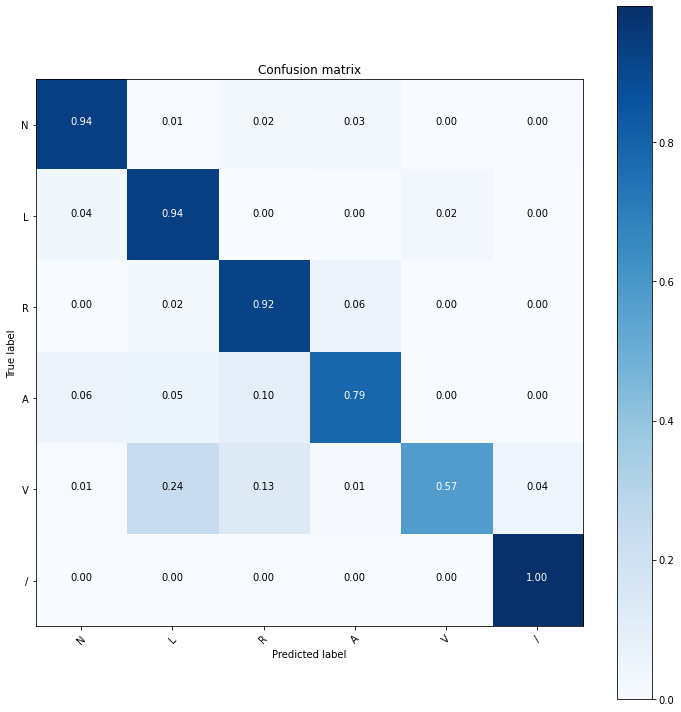

In [62]:
cm = confusion_matrix(y_true=truth, y_pred=preds)
plot_confusion_matrix(cm=cm,normalize=True,classes=classes)

# 7. Save the Parameters and Export ONNX Model

In [63]:
torch.save(brevitas_model.state_dict(),'./save/ECG_1D_w4a4_parameter_final.pth')

In [20]:
 import brevitas.onnx as bo

In [ ]:
export_onnx_path="./save/ECG_1D_w4a4_final.onnx"
input_shape=(1,1,130,1)
bo.export_finn_onnx(brevitas_model, input_shape, export_onnx_path)

In [22]:
from finn.core.modelwrapper import ModelWrapper
from finn.core.datatype import DataType

In [65]:
model_file="./save/ECG_1D_w4a4_final.onnx"

model=ModelWrapper(model_file)
model.set_tensor_datatype(model.graph.input[0].name, DataType.UINT8)
model.save(model_file)